In [1]:
import sys
import os


# Get the absolute path to the directory containing 'src'
project_dir = os.path.abspath("..")
sys.path.append(project_dir)

In [3]:
from src.simulation.simulation_space import DestinationPoint, StartingPoint, SimulationSpace
from src.simulation.agent import Agent
from src.simulation.simulation import Simulation

## Create Simulated Trajectory Training Data

Simulation complete! All agents have reached their destinations.


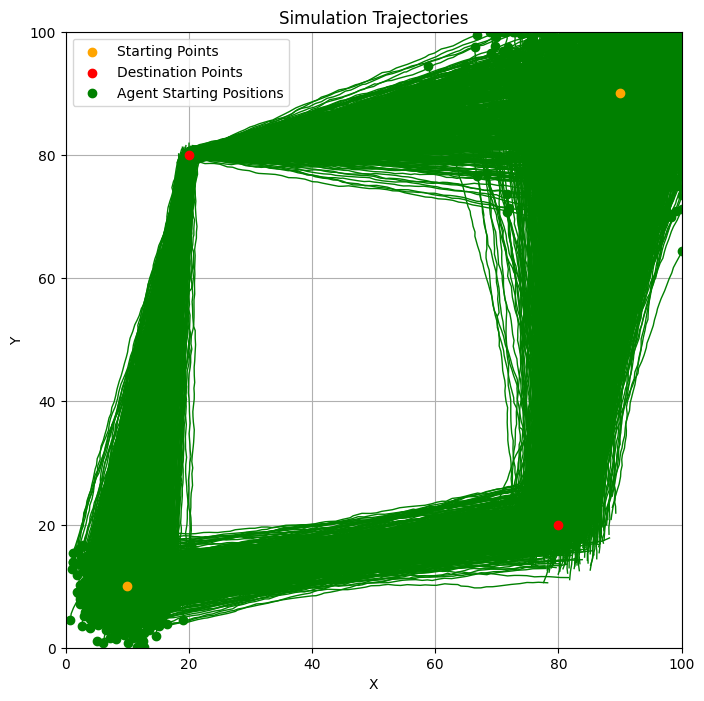

In [4]:
# Define destination points with the new stopping point logic
destination_1 = DestinationPoint(x=20, y=80, stop_mean=2.0, stop_std=0.5)
destination_2 = DestinationPoint(x=80, y=20, stop_mean=5.0, stop_std=3.0)

# Initialize the simulation space
space = SimulationSpace(size=(100, 100), destination_points=[destination_1, destination_2])

# Add starting points
starting_point_1 = StartingPoint(x=10, y=10, simulation_space=space, position_std=3.0, destination_probs=[0.8, 0.2])
starting_point_2 = StartingPoint(x=90, y=90, simulation_space=space, position_std=8.0, destination_probs=[0.2, 0.8])
space.add_starting_point(starting_point_1)
space.add_starting_point(starting_point_2)

# Create agents
agents = []
for _ in range(5000):  # Generate agents
    agent = Agent(simulation_space=space)
    agent.initialize_agent()
    agents.append(agent)

# Add agents to the simulation space
for agent in agents:
    space.add_agent(agent)

# Run the simulation
simulation = Simulation(simulation_space=space, agents=agents)
simulation.run_simulation()

# Visualize the trajectories
simulation.visualize_trajectories()

### Create Test Data from Simulation

Simulation complete! All agents have reached their destinations.


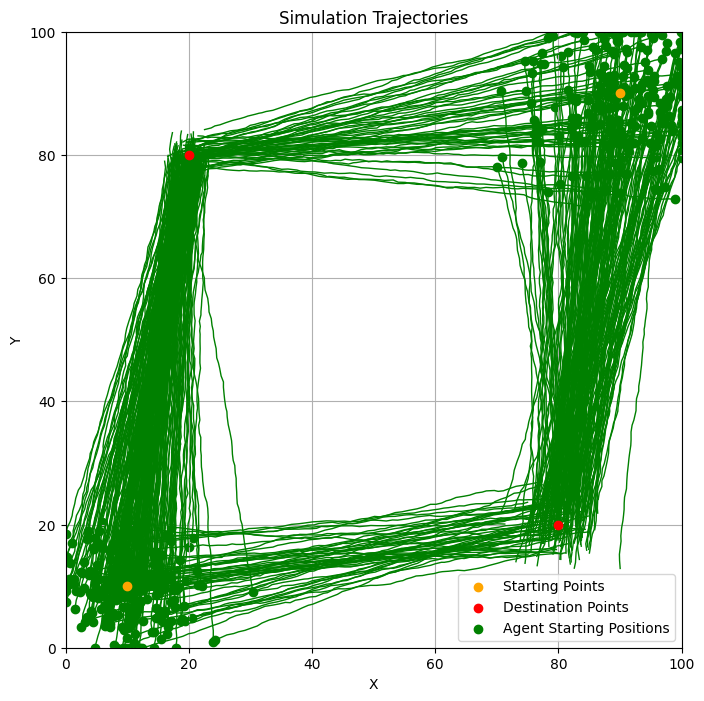

In [5]:
# Define destination points with the new stopping point logic
destination_1 = DestinationPoint(x=20, y=80, stop_mean=4.0, stop_std=1.5)
destination_2 = DestinationPoint(x=80, y=20, stop_mean=7.0, stop_std=3.0)

# Initialize the simulation space
space = SimulationSpace(size=(100, 100), destination_points=[destination_1, destination_2])

# Add starting points
starting_point_1 = StartingPoint(x=10, y=10, simulation_space=space, position_std=5.0, destination_probs=[0.8, 0.2])
starting_point_2 = StartingPoint(x=90, y=90, simulation_space=space, position_std=8.0, destination_probs=[0.2, 0.8])
space.add_starting_point(starting_point_1)
space.add_starting_point(starting_point_2)

# Create agents
agents = []
for _ in range(500):  # Generate agents
    agent = Agent(simulation_space=space)
    agent.initialize_agent()
    agents.append(agent)

# Add agents to the simulation space
for agent in agents:
    space.add_agent(agent)

# Run the simulation
test_simulation = Simulation(simulation_space=space, agents=agents)
test_simulation.run_simulation()

# Visualize the trajectories
test_simulation.visualize_trajectories()

test_trajectories = test_simulation.trajectories

## K-means on Summary Statistics

In [5]:
trajectories = simulation.trajectories

In [6]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# Assuming `trajectories` is a dictionary {id: [(x1, y1), (x2, y2), ...]}
def calculate_summary_stats(trajectories):
    summary_stats = []

    for traj_id, traj in trajectories.items():
        traj = np.array(traj)
        start_point = traj[0]  # Starting point (x1, y1)

        # Calculate direction as the angle of the vector from the first to the second point
        if len(traj) > 1:
            direction_vector = traj[1] - traj[0]
            direction_angle = np.arctan2(direction_vector[1], direction_vector[0])  # Angle in radians
        else:
            direction_angle = 0  # No direction for single-point trajectories

        # Calculate average speed
        if len(traj) > 1:
            distances = np.linalg.norm(np.diff(traj, axis=0), axis=1)
            total_distance = np.sum(distances)
            total_time = len(traj) - 1  # Assuming time steps are uniform
            average_speed = total_distance / total_time
        else:
            average_speed = 0  # No speed for single-point trajectories

        # Append stats to the list
        summary_stats.append({
            "Trajectory ID": traj_id,
            "Start X": start_point[0],
            "Start Y": start_point[1],
            "Direction": direction_angle,
            "Speed": average_speed
        })

    # Convert to a DataFrame
    return pd.DataFrame(summary_stats)

# Calculate summary stats
summary_df = calculate_summary_stats(trajectories)
summary_df.head()

,Trajectory ID,Start X,Start Y,Direction,Speed
0,0,87.599744,91.175902,-1.578013,1.013616
1,1,87.135540,85.046161,-1.738606,1.030171
2,2,76.021875,93.613212,-1.595936,0.965380
3,3,99.243987,93.367021,-1.782331,0.994674
4,4,84.491388,84.942975,-1.623107,0.998837


In [7]:
from sklearn.preprocessing import StandardScaler

# Features for clustering
features = ["Start X", "Start Y", "Direction", "Speed"]

# Normalize the features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(summary_df[features])

# Fit K-Means
kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
summary_df["Cluster"] = kmeans.fit_predict(normalized_features)

# Display the DataFrame with clusters
print(summary_df.head())

   Trajectory ID    Start X    Start Y  Direction     Speed  Cluster
0              0  87.599744  91.175902  -1.578013  1.013616        0
1              1  87.135540  85.046161  -1.738606  1.030171        0
2              2  76.021875  93.613212  -1.595936  0.965380        0
3              3  99.243987  93.367021  -1.782331  0.994674        0
4              4  84.491388  84.942975  -1.623107  0.998837        0


In [8]:
# Map cluster assignments back to trajectories
trajectory_clusters = {row["Trajectory ID"]: row["Cluster"] for _, row in summary_df.iterrows()}

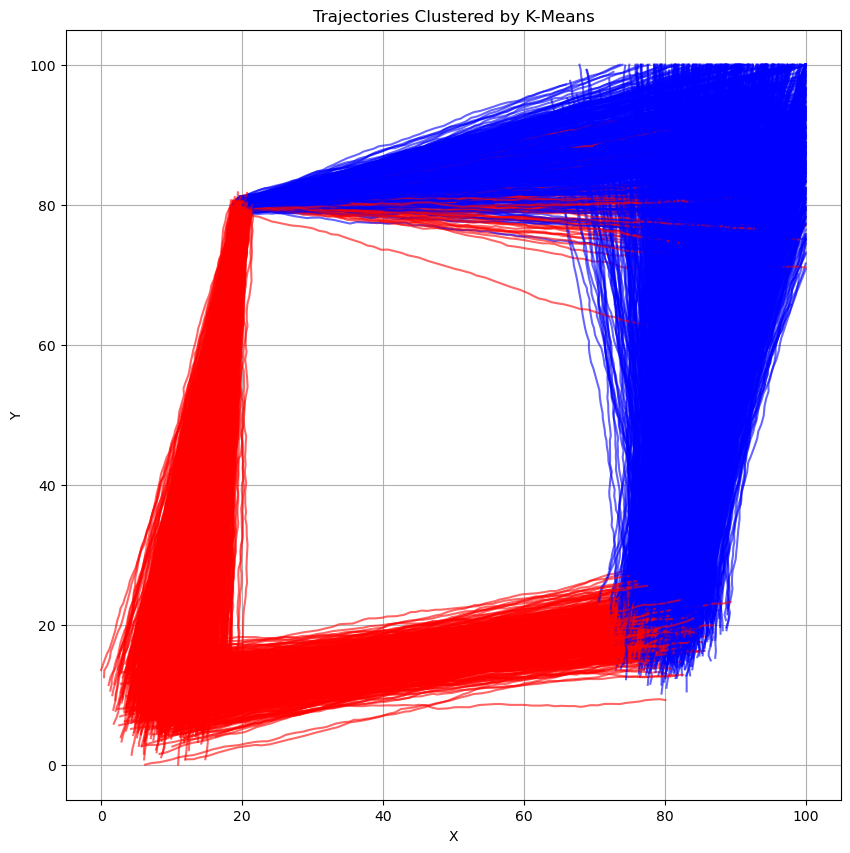

In [9]:
import matplotlib.pyplot as plt

# Define colors for the clusters
cluster_colors = {0: "blue", 1: "red"}

plt.figure(figsize=(10, 10))
for traj_id, traj in trajectories.items():
    traj = np.array(traj)
    cluster = trajectory_clusters[traj_id]
    color = cluster_colors[cluster]

    # Plot trajectory
    plt.plot(traj[:, 0], traj[:, 1], color=color, alpha=0.6)

plt.title("Trajectories Clustered by K-Means")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid()
plt.show()

## K-means with Destination Points

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Extract destination points
def extract_destination_points(trajectories):
    """
    Extract destination points (last points) from trajectories.

    Parameters:
        trajectories (dict): Dictionary of trajectories {id: [(x1, y1), (x2, y2), ...]}.

    Returns:
        np.ndarray: Array of destination points, shape (num_trajectories, 2).
    """
    destination_points = np.array([traj[-1] for traj in trajectories.values()])
    return destination_points

destination_points = extract_destination_points(trajectories)
print(f"Destination Points Shape: {destination_points.shape}")

Destination Points Shape: (5000, 2)


In [11]:
# Apply K-Means clustering
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(destination_points)

# Assign cluster labels back to trajectories
trajectory_clusters = {key: cluster_labels[idx] for idx, key in enumerate(trajectories.keys())}

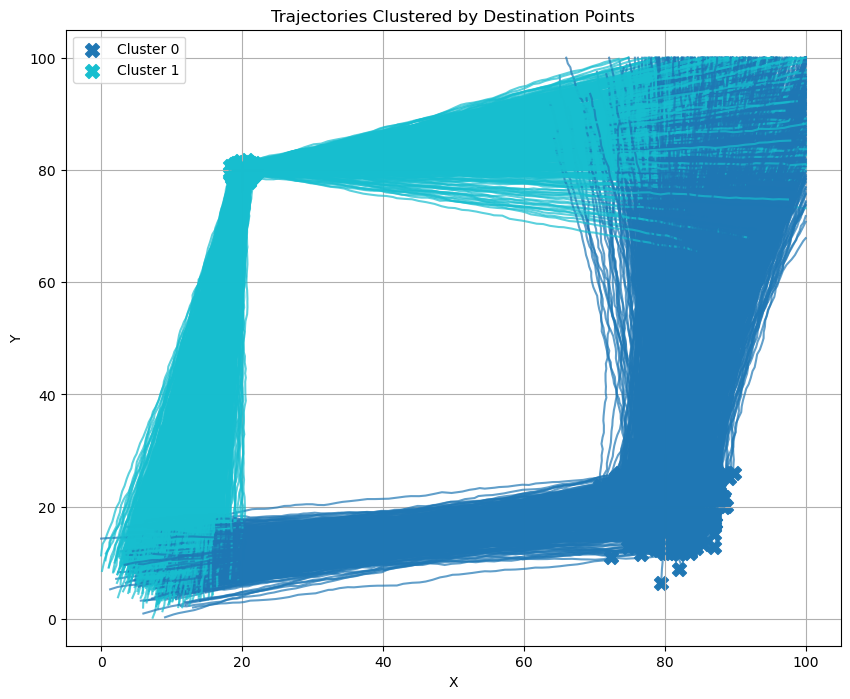

In [12]:
# Visualize clustered destinations and trajectories
colors = plt.cm.tab10(np.linspace(0, 1, num_clusters))

plt.figure(figsize=(10, 8))

# Plot trajectories with cluster colors
for traj_id, traj in trajectories.items():
    cluster_id = trajectory_clusters[traj_id]
    plt.plot(*zip(*traj), color=colors[cluster_id], alpha=0.7)

# Plot destination points with cluster colors and add to legend
for cluster_id in range(num_clusters):
    plt.scatter(
        destination_points[cluster_labels == cluster_id, 0], 
        destination_points[cluster_labels == cluster_id, 1], 
        c=[colors[cluster_id]], 
        label=f"Cluster {cluster_id}",
        s=100,
        marker="X"
    )

plt.title("Trajectories Clustered by Destination Points")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc="best")
plt.grid()
plt.show()

In [26]:
goals = [[20, 80], [80, 20]]

## GMM with Goal Based Summary Statistics

In [27]:
import numpy as np
import pandas as pd

def compute_goal_relative_features(trajectories, goals, trajectory_clusters):
    """
    Compute goal-relative features for trajectories.

    Parameters:
        trajectories (dict): Dictionary of trajectories {id: [(x1, y1), (x2, y2), ...]}.
        goals (np.ndarray): Array of goal cluster centers, shape (num_goals, 2).
        trajectory_clusters (dict): Mapping of trajectory IDs to goal cluster labels.

    Returns:
        pd.DataFrame: DataFrame with goal-relative features for all trajectories.
    """
    features = []

    for traj_id, traj in trajectories.items():
        traj = np.array(traj)  # Convert trajectory to numpy array
        goal_label = trajectory_clusters[traj_id]  # Get the assigned goal cluster
        goal = goals[goal_label]  # Get the goal's coordinates

        # Distance to goal
        distances_to_goal = np.linalg.norm(traj - goal, axis=1)
        avg_distance_to_goal = np.mean(distances_to_goal)

        # Direction to goal
        directions_to_goal = goal - traj
        norm_directions = np.linalg.norm(directions_to_goal, axis=1, keepdims=True)
        normalized_directions = directions_to_goal / (norm_directions + 1e-10)  # Avoid division by zero
        avg_direction_to_goal = np.mean(normalized_directions, axis=0)

        # Deviation from goal path
        start_point = traj[0]
        straight_path_vector = goal - start_point
        norm_straight_path = np.linalg.norm(straight_path_vector)

        if norm_straight_path > 0:  # To handle the case of overlapping start and goal
            straight_path_unit = straight_path_vector / norm_straight_path
            deviations = np.linalg.norm(
                traj - (start_point + np.outer((traj - start_point) @ straight_path_unit, straight_path_unit)),
                axis=1,
            )
            avg_deviation_from_path = np.mean(deviations)
        else:
            avg_deviation_from_path = 0.0

        # Combine features
        feature = {
            "Trajectory_ID": traj_id,
            "Avg_Distance_To_Goal": avg_distance_to_goal,
            "Avg_Dir_To_Goal_X": avg_direction_to_goal[0],
            "Avg_Dir_To_Goal_Y": avg_direction_to_goal[1],
            "Avg_Deviation_From_Path": avg_deviation_from_path,
        }
        features.append(feature)

    # Create a DataFrame
    return pd.DataFrame(features)

# Example usage
goal_relative_features = compute_goal_relative_features(trajectories, goals, trajectory_clusters)

# Display the first few rows
goal_relative_features.head()

,Trajectory_ID,Avg_Distance_To_Goal,Avg_Dir_To_Goal_X,Avg_Dir_To_Goal_Y,Avg_Deviation_From_Path
0,0,66.243952,-0.899476,0.339670,33.961133
1,1,72.153927,0.901725,-0.333409,33.809180
2,2,70.371231,0.903012,-0.321424,34.861279
3,3,72.253623,-0.307203,0.912124,31.367755
4,4,71.256451,0.898451,-0.337333,35.355717


In [30]:
from sklearn.mixture import GaussianMixture

# Select features for GMM training
feature_columns = [
    "Avg_Distance_To_Goal",
    "Avg_Dir_To_Goal_X",
    "Avg_Dir_To_Goal_Y",
    "Avg_Deviation_From_Path",
]

# Extract feature values
X = goal_relative_features[feature_columns].values

# Initialize and train the GMM
num_mixtures = 2
gmm = GaussianMixture(n_components=num_mixtures, covariance_type="full", random_state=42)
gmm.fit(X)

# Predict cluster assignments for each trajectory
goal_relative_features["GMM_Cluster"] = gmm.predict(X)

# Display the first few rows with cluster assignments
goal_relative_features.head()

,Trajectory_ID,Avg_Distance_To_Goal,Avg_Dir_To_Goal_X,Avg_Dir_To_Goal_Y,Avg_Deviation_From_Path,GMM_Cluster
0,0,66.243952,-0.899476,0.339670,33.961133,0
1,1,72.153927,0.901725,-0.333409,33.809180,1
2,2,70.371231,0.903012,-0.321424,34.861279,1
3,3,72.253623,-0.307203,0.912124,31.367755,0
4,4,71.256451,0.898451,-0.337333,35.355717,1


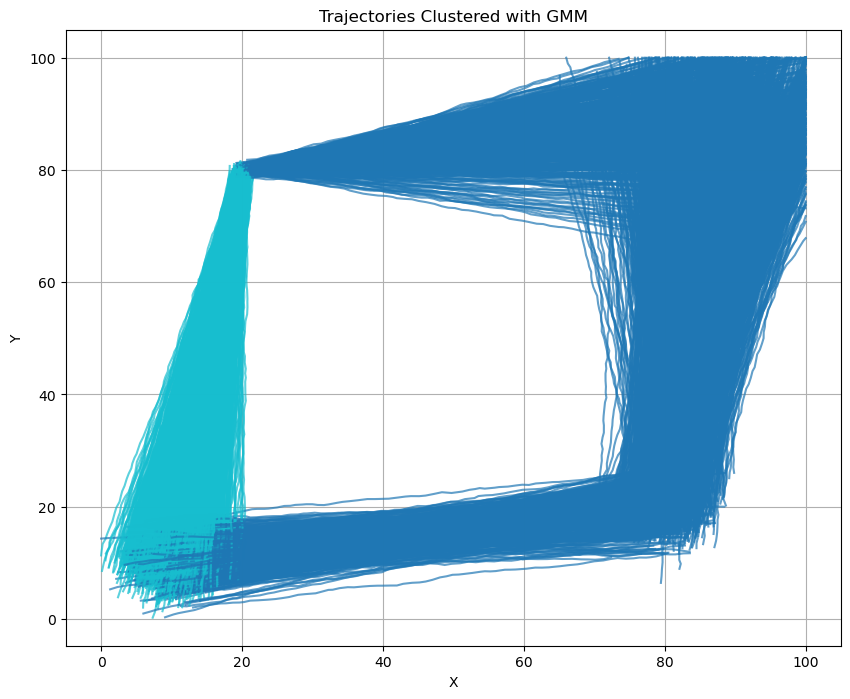

In [31]:
import matplotlib.pyplot as plt

# Define colors for each cluster
colors = plt.cm.tab10(np.linspace(0, 1, num_mixtures))

# Plot the trajectories with GMM cluster assignments
plt.figure(figsize=(10, 8))
for idx, (traj_id, traj) in enumerate(trajectories.items()):
    cluster_id = goal_relative_features.loc[goal_relative_features["Trajectory_ID"] == traj_id, "GMM_Cluster"].values[0]
    plt.plot(*zip(*traj), color=colors[cluster_id], alpha=0.7)

plt.title("Trajectories Clustered with GMM")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid()
plt.show()

## Supervised Goal Prediction

In [32]:
import numpy as np
import torch
from torch.utils.data import Dataset

device = torch.device("cpu")

class TrajectoryGoalDataset(Dataset):
    def __init__(self, trajectories, trajectory_clusters, max_len):
        """
        Dataset for trajectory-to-goal mapping.

        Parameters:
            trajectories (dict): Dictionary of trajectories {id: [(x1, y1), (x2, y2), ...]}.
            trajectory_clusters (dict): Dictionary of cluster labels {id: cluster_label}.
            max_len (int): Maximum trajectory length for padding or truncation.
        """
        self.inputs = []
        self.targets = []
        self.max_len = max_len

        def interpolate_trajectory(trajectory, target_length):
            """
            Linearly interpolate a trajectory to a target length.

            Parameters:
                trajectory (list of tuples): Original trajectory [(x1, y1), (x2, y2), ...].
                target_length (int): Desired length of the trajectory.

            Returns:
                np.ndarray: Interpolated trajectory of shape (target_length, 2).
            """
            original_length = len(trajectory)
            trajectory = np.array(trajectory)

            # Create evenly spaced indices for the original and target trajectories
            original_indices = np.linspace(0, original_length - 1, num=original_length)
            target_indices = np.linspace(0, original_length - 1, num=target_length)

            # Interpolate x and y coordinates separately
            x = np.interp(target_indices, original_indices, trajectory[:, 0])
            y = np.interp(target_indices, original_indices, trajectory[:, 1])

            return np.column_stack((x, y))  # Combine x and y into a single array

        # Prepare data and labels
        for traj_id, traj in trajectories.items():
            interpolated_traj = interpolate_trajectory(traj, max_len)
            self.inputs.append(interpolated_traj)
            self.targets.append(trajectory_clusters[traj_id])

        # Convert to single numpy array first, then to tensor
        self.inputs = torch.tensor(np.array(self.inputs), dtype=torch.float32)  # Shape: (num_trajectories, max_len, 2)
        self.targets = torch.tensor(self.targets, dtype=torch.long)  # Shape: (num_trajectories,)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Calculate the maximum trajectory length from both datasets
max_len_train = max(len(traj) for traj in trajectories.values())
max_len_test = max(len(traj) for traj in test_trajectories.values())
max_len = max(max_len_train, max_len_test)  # Use the longest length across both datasets

# Prepare the datasets
train_dataset = TrajectoryGoalDataset(trajectories, trajectory_clusters, max_len)
test_dataset = TrajectoryGoalDataset(test_trajectories, trajectory_clusters, max_len)

# Print dataset shapes for verification
print(f"Training Data Shape: {train_dataset.inputs.shape}, Labels Shape: {train_dataset.targets.shape}")
print(f"Testing Data Shape: {test_dataset.inputs.shape}, Labels Shape: {test_dataset.targets.shape}")


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [21]:
import torch
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        """
        A simple RNN for trajectory-to-goal classification.

        Parameters:
            input_dim (int): Dimension of input features (e.g., 2 for x, y coordinates).
            hidden_dim (int): Dimension of the hidden state.
            output_dim (int): Number of output classes (e.g., 2 for two goals).
            num_layers (int): Number of RNN layers (default is 1).
        """
        super(SimpleRNN, self).__init__()
        
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.hidden_dim = hidden_dim

    def forward(self, x):
        """
        Forward pass through the RNN.
        
        Parameters:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, input_dim).

        Returns:
            torch.Tensor: Output logits of shape (batch_size, output_dim).
        """
        # RNN returns the hidden states for all time steps and the final hidden state
        batch_size = x.size(0)
        h0 = torch.zeros(self.rnn.num_layers, batch_size, self.hidden_dim, device=x.device)
        out, _ = self.rnn(x, h0)  # `out` shape: (batch_size, seq_len, hidden_dim)
        
        # Use only the last hidden state for classification
        last_hidden_state = out[:, -1, :]  # Shape: (batch_size, hidden_dim)
        logits = self.fc(last_hidden_state)  # Shape: (batch_size, output_dim)
        
        return logits


In [22]:
# Define the model, loss function, and optimizer
input_dim = 2  # x, y coordinates
hidden_dim = 64  # Adjust based on experiment
output_dim = 2  # Number of goals
num_layers = 1  # Single-layer RNN


In [23]:
import torch.optim as optim
from torch.utils.data import DataLoader

model = SimpleRNN(input_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Hyperparameters
batch_size = 32
learning_rate = 1e-3
num_epochs = 20

# Define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0

    for inputs, labels in train_loader:
        # Move data to the appropriate device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    #if not (epoch+1) % 10:
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_train_loss:.4f}")

# Save the trained model
#torch.save(model.state_dict(), "trajectory_goal_rnn.pth")

Epoch [1/20], Loss: 0.0800
Epoch [2/20], Loss: 0.0037
Epoch [3/20], Loss: 0.0017
Epoch [4/20], Loss: 0.0010
Epoch [5/20], Loss: 0.0007
Epoch [6/20], Loss: 0.0005
Epoch [7/20], Loss: 0.0004
Epoch [8/20], Loss: 0.0003
Epoch [9/20], Loss: 0.0002
Epoch [10/20], Loss: 0.0002
Epoch [11/20], Loss: 0.0002
Epoch [12/20], Loss: 0.0001
Epoch [13/20], Loss: 0.0001
Epoch [14/20], Loss: 0.0001
Epoch [15/20], Loss: 0.0001
Epoch [16/20], Loss: 0.0001
Epoch [17/20], Loss: 0.0001
Epoch [18/20], Loss: 0.0001
Epoch [19/20], Loss: 0.0001
Epoch [20/20], Loss: 0.0001


In [24]:
# Validation loop on training data
model.eval()  # Set model to evaluation mode
train_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in train_loader:  # Using the train_loader
        # Move data to the appropriate device
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        train_loss += loss.item()

        # Get predictions
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

avg_train_loss = train_loss / len(train_loader)
accuracy = correct / total * 100

print(f"Training Data Validation Loss: {avg_train_loss:.4f}, Accuracy: {accuracy:.2f}%")

Training Data Validation Loss: 0.0000, Accuracy: 100.00%


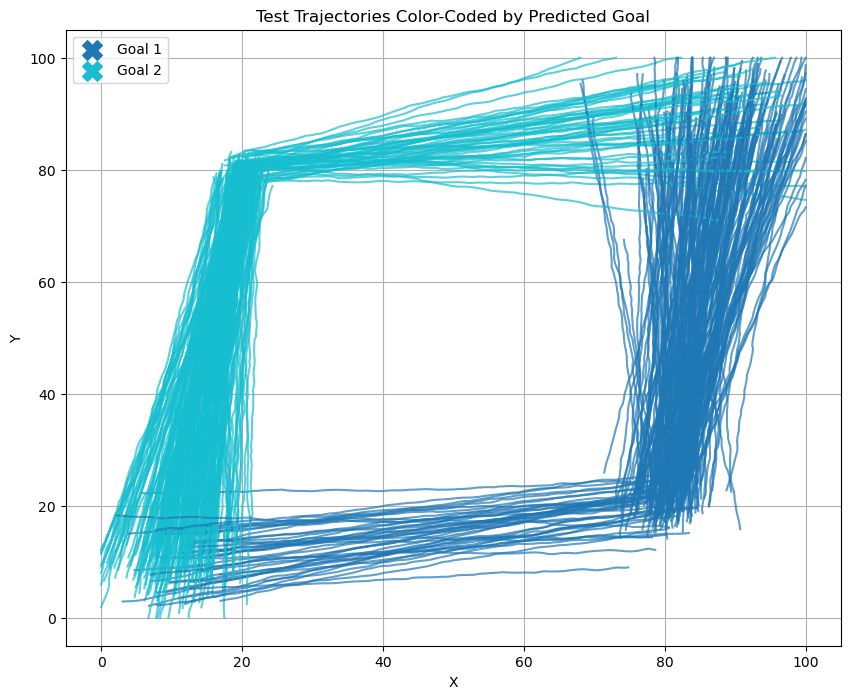

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set the model to evaluation mode
model.eval()

# Store predictions and trajectory data
predicted_labels = []
test_trajectories = []

with torch.no_grad():
    for inputs, _ in test_loader:  # Assuming test_loader is defined for the test dataset
        inputs = inputs.to(device)  # Send to the same device as the model
        
        # Get predictions
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        
        # Store the predictions
        predicted_labels.extend(preds.cpu().numpy())
        
        # Store trajectories for visualization
        test_trajectories.extend(inputs.cpu().numpy())

# Convert to numpy arrays for easier processing
predicted_labels = np.array(predicted_labels)
test_trajectories = np.array(test_trajectories)  # Shape: (num_trajectories, seq_len, 2)

# Visualization
colors = plt.cm.tab10(np.linspace(0, 1, 2))  # Use distinct colors for each goal

plt.figure(figsize=(10, 8))
for idx, trajectory in enumerate(test_trajectories):
    predicted_goal = predicted_labels[idx]
    plt.plot(trajectory[:, 0], trajectory[:, 1], color=colors[predicted_goal], alpha=0.7)

# Optionally plot the destination points for reference
for i, goal in enumerate(goals):  # Assuming `goals` is the list of goal destination points
    plt.scatter(goal[0], goal[1], color=colors[i], label=f"Goal {i + 1}", marker="X", s=200)

plt.title("Test Trajectories Color-Coded by Predicted Goal")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid()
plt.show()

In [29]:
# Create partial trajectories for testing
partial_trajectories = []
for traj in test_trajectories:
    partial_length = int(0.8 * len(traj))  # Use the first 80% of the trajectory
    partial_traj = traj[:partial_length]  # Extract first 80%
    
    # Linearly interpolate to match the original max_len
    interpolated_traj = interpolate_trajectory(partial_traj, max_len)
    partial_trajectories.append(interpolated_traj)

# Convert to tensor for model prediction
partial_trajectories = torch.tensor(partial_trajectories, dtype=torch.float32).to(device)

# Predict goals for partial trajectories
model.eval()
with torch.no_grad():
    outputs = model(partial_trajectories)
    predicted_labels_partial = torch.argmax(outputs, dim=1).cpu().numpy()

# Visualization
colors = plt.cm.tab10(np.linspace(0, 1, 2))  # Use distinct colors for each goal

plt.figure(figsize=(10, 8))
for idx, trajectory in enumerate(partial_trajectories.cpu().numpy()):
    predicted_goal = predicted_labels_partial[idx]
    plt.plot(trajectory[:, 0], trajectory[:, 1], color=colors[predicted_goal], alpha=0.7)

# Optionally plot the destination points for reference
for i, goal in enumerate(goals):  # Assuming `goals` is the list of goal destination points
    plt.scatter(goal[0], goal[1], color=colors[i], label=f"Goal {i + 1}", marker="X", s=200)

plt.title("Partial Test Trajectories (80%) Color-Coded by Predicted Goal")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid()
plt.show()

NameError: name 'interpolate_trajectory' is not defined

In [ ]:
# Create partial trajectories for testing
partial_trajectories = []
for traj in test_trajectories:
    partial_length = int(0.6 * len(traj))  # Use the first 80% of the trajectory
    partial_traj = traj[:partial_length]  # Extract first 80%
    
    # Linearly interpolate to match the original max_len
    interpolated_traj = interpolate_trajectory(partial_traj, max_len)
    partial_trajectories.append(interpolated_traj)

# Convert to tensor for model prediction
partial_trajectories = torch.tensor(partial_trajectories, dtype=torch.float32).to(device)

# Predict goals for partial trajectories
model.eval()
with torch.no_grad():
    outputs = model(partial_trajectories)
    predicted_labels_partial = torch.argmax(outputs, dim=1).cpu().numpy()

# Visualization
colors = plt.cm.tab10(np.linspace(0, 1, 2))  # Use distinct colors for each goal

plt.figure(figsize=(10, 8))
for idx, trajectory in enumerate(partial_trajectories.cpu().numpy()):
    predicted_goal = predicted_labels_partial[idx]
    plt.plot(trajectory[:, 0], trajectory[:, 1], color=colors[predicted_goal], alpha=0.7)

# Optionally plot the destination points for reference
for i, goal in enumerate(goals):  # Assuming `goals` is the list of goal destination points
    plt.scatter(goal[0], goal[1], color=colors[i], label=f"Goal {i + 1}", marker="X", s=200)

plt.title("Partial Test Trajectories (60%) Color-Coded by Predicted Goal")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Create partial trajectories for testing
partial_trajectories = []
for traj in test_trajectories:
    partial_length = int(0.4 * len(traj))  # Use the first 80% of the trajectory
    partial_traj = traj[:partial_length]  # Extract first 80%
    
    # Linearly interpolate to match the original max_len
    interpolated_traj = interpolate_trajectory(partial_traj, max_len)
    partial_trajectories.append(interpolated_traj)

# Convert to tensor for model prediction
partial_trajectories = torch.tensor(partial_trajectories, dtype=torch.float32).to(device)

# Predict goals for partial trajectories
model.eval()
with torch.no_grad():
    outputs = model(partial_trajectories)
    predicted_labels_partial = torch.argmax(outputs, dim=1).cpu().numpy()

# Visualization
colors = plt.cm.tab10(np.linspace(0, 1, 2))  # Use distinct colors for each goal

plt.figure(figsize=(10, 8))
for idx, trajectory in enumerate(partial_trajectories.cpu().numpy()):
    predicted_goal = predicted_labels_partial[idx]
    plt.plot(trajectory[:, 0], trajectory[:, 1], color=colors[predicted_goal], alpha=0.7)

# Optionally plot the destination points for reference
for i, goal in enumerate(goals):  # Assuming `goals` is the list of goal destination points
    plt.scatter(goal[0], goal[1], color=colors[i], label=f"Goal {i + 1}", marker="X", s=200)

plt.title("Partial Test Trajectories (40%) Color-Coded by Predicted Goal")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Create partial trajectories for testing
partial_trajectories = []
for traj in test_trajectories:
    partial_length = int(0.2 * len(traj))  # Use the first 80% of the trajectory
    partial_traj = traj[:partial_length]  # Extract first 80%
    
    # Linearly interpolate to match the original max_len
    interpolated_traj = interpolate_trajectory(partial_traj, max_len)
    partial_trajectories.append(interpolated_traj)

# Convert to tensor for model prediction
partial_trajectories = torch.tensor(partial_trajectories, dtype=torch.float32).to(device)

# Predict goals for partial trajectories
model.eval()
with torch.no_grad():
    outputs = model(partial_trajectories)
    predicted_labels_partial = torch.argmax(outputs, dim=1).cpu().numpy()

# Visualization
colors = plt.cm.tab10(np.linspace(0, 1, 2))  # Use distinct colors for each goal

plt.figure(figsize=(10, 8))
for idx, trajectory in enumerate(partial_trajectories.cpu().numpy()):
    predicted_goal = predicted_labels_partial[idx]
    plt.plot(trajectory[:, 0], trajectory[:, 1], color=colors[predicted_goal], alpha=0.7)

# Optionally plot the destination points for reference
for i, goal in enumerate(goals):  # Assuming `goals` is the list of goal destination points
    plt.scatter(goal[0], goal[1], color=colors[i], label=f"Goal {i + 1}", marker="X", s=200)

plt.title("Partial Test Trajectories (20%) Color-Coded by Predicted Goal")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Create partial trajectories for testing
partial_trajectories = []
for traj in test_trajectories:
    partial_length = int(0.1 * len(traj))  # Use the first 80% of the trajectory
    partial_traj = traj[:partial_length]  # Extract first 80%
    
    # Linearly interpolate to match the original max_len
    interpolated_traj = interpolate_trajectory(partial_traj, max_len)
    partial_trajectories.append(interpolated_traj)

# Convert to tensor for model prediction
partial_trajectories = torch.tensor(partial_trajectories, dtype=torch.float32).to(device)

# Predict goals for partial trajectories
model.eval()
with torch.no_grad():
    outputs = model(partial_trajectories)
    predicted_labels_partial = torch.argmax(outputs, dim=1).cpu().numpy()

# Visualization
colors = plt.cm.tab10(np.linspace(0, 1, 2))  # Use distinct colors for each goal

plt.figure(figsize=(10, 8))
for idx, trajectory in enumerate(partial_trajectories.cpu().numpy()):
    predicted_goal = predicted_labels_partial[idx]
    plt.plot(trajectory[:, 0], trajectory[:, 1], color=colors[predicted_goal], alpha=0.7)

# Optionally plot the destination points for reference
for i, goal in enumerate(goals):  # Assuming `goals` is the list of goal destination points
    plt.scatter(goal[0], goal[1], color=colors[i], label=f"Goal {i + 1}", marker="X", s=200)

plt.title("Partial Test Trajectories (10%) Color-Coded by Predicted Goal")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid()
plt.show()

## HMM Model  
Here, we will design and implement a HMM model for the trajectories based on their probable goals.

In [6]:
import pystan
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Define the Stan model as a string
stan_code = """
data {
  int<lower=0> N;    // number of data points
  vector[N] y;       // observed data
}
parameters {
  real mu;                    // mean of the distribution
  real<lower=0> sigma;        // standard deviation of the distribution
}
model {
  // Priors
  mu ~ normal(0, 10);
  sigma ~ cauchy(0, 5);
  
  // Likelihood
  y ~ normal(mu, sigma);
}
"""

In [8]:
# Compile the model (this may take a minute the first time)
sm = pystan.StanModel(model_code=stan_code)

# Generate synthetic data: Let's assume true mu=5 and sigma=2
np.random.seed(42)
N = 100
true_mu = 5.0
true_sigma = 2.0
y_data = np.random.normal(true_mu, true_sigma, size=N)

# Prepare data for Stan
data = {
    'N': N,
    'y': y_data
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2d238f4c636f6ff23eb13b904d1add53 NOW.
In file included from /var/folders/38/k8ptv94x02v3qc6vywd5sfv40000gn/T/pystan__rd5cxcn/stanfit4anon_model_2d238f4c636f6ff23eb13b904d1add53_8537051146129291246.cpp:1315:
In file included from /Users/nigeldoering/miniconda3/envs/pystan_env/lib/python3.11/site-packages/numpy/_core/include/numpy/arrayobject.h:5:
In file included from /Users/nigeldoering/miniconda3/envs/pystan_env/lib/python3.11/site-packages/numpy/_core/include/numpy/ndarrayobject.h:12:
In file included from /Users/nigeldoering/miniconda3/envs/pystan_env/lib/python3.11/site-packages/numpy/_core/include/numpy/ndarraytypes.h:1913:
/Users/nigeldoering/miniconda3/envs/pystan_env/lib/python3.11/site-packages/numpy/_core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
   17 | #warning "Using deprecated NumPy AP

In [9]:
# Fit the model using sampling
fit = sm.sampling(data=data, iter=2000, warmup=1000, chains=4, seed=42)

# Print the summary of the fitted model
print(fit)

Process SpawnPoolWorker-1:
Process SpawnPoolWorker-2:
Process SpawnPoolWorker-3:
Process SpawnPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/nigeldoering/miniconda3/envs/pystan_env/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/nigeldoering/miniconda3/envs/pystan_env/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/nigeldoering/miniconda3/envs/pystan_env/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/nigeldoering/miniconda3/envs/pystan_env/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/nigeldoering/miniconda3/envs/pystan_env/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users

KeyboardInterrupt: 

In [ ]:
# Extract samples to inspect the posterior distributions
samples = fit.extract(permuted=True)
mu_samples = samples['mu']
sigma_samples = samples['sigma']

# Plot the posterior distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(mu_samples, bins=30, density=True, alpha=0.7)
plt.axvline(true_mu, color='red', linestyle='--', label='True mu')
plt.title('Posterior distribution of mu')
plt.xlabel('mu')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(sigma_samples, bins=30, density=True, alpha=0.7)
plt.axvline(true_sigma, color='red', linestyle='--', label='True sigma')
plt.title('Posterior distribution of sigma')
plt.xlabel('sigma')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
fit = sm.sampling(data=data, iter=2000, warmup=1000, chains=1, seed=42)

In [10]:
fit

NameError: name 'fit' is not defined